# Segmenting and Clustering Neighborhoods in Los Angeles

This project aims to survey and explore neighborhoods in Los Angeles (LA), California. LA is a big place, so to narrow down the scope of this investigation a bit, let's only consider zip codes that have a [sectional center facility](https://en.wikipedia.org/wiki/ZIP_Code#Structure_and_allocation) of 900 i.e. zip codes starting with 900!

After the data has been loaded and preprocessed, a call to the Foursquare API will be made to explore and segment the neighborhoods in LA. Foursquare's **explore** function will be utilized to get the most common venue categories in each neighborhood, and then this feature will be used to group the neighborhoods into clusters. The clustering algorithm of choice to complete this task will be the *k*-means. Finally, the Folium library will be used to visualize the neighborhoods and their emerging clusters.

## Table of Contents 

1. **Loading and Preprocessing Datasets**

2. **Exploring the neighborhoods in LA**

3. **Analyzing the neighborhoods in LA**

4. **Clustering the neighborhoods in LA**

5. **Examining the clusters**


In [1]:
import requests # library to handle requests
#!pip install beautifulsoup4
from bs4 import BeautifulSoup # library for web scraping
import pandas as pd # library to process data as dataframes
import numpy as np # library to handle data in a vectorized manner

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
print("Libraries successfully installed!")

Libraries successfully installed!


## 1. Loading and Preprocessing Datasets

In [2]:
la_data = pd.read_csv('Addresses_in_the_City_of_LA.csv')
la_data.head(10)

,STR_NM,STR_SFX_CD,ZIP_CD,LAT,LON
0,IVAR,AVE,90028,34.10369,-118.32831
1,BELFORD,AVE,90045,33.95675,-118.38381
2,MAUBERT,AVE,90027,34.09890,-118.29008
3,BELFORD,AVE,90045,33.95675,-118.38381
4,CHEREMOYA,AVE,90068,34.10839,-118.32073
5,CRESTA,DR,90035,34.04616,-118.38767
6,FORTUNA,ST,90011,33.99288,-118.24543
7,CRESCENT,DR,90046,34.11356,-118.38027
8,LINDBROOK,DR,90024,34.05968,-118.44521
9,BLUE JAY,WAY,90069,34.09843,-118.38705


In [3]:
la_data.shape

(576727, 5)

We only want the zip codes that start with 900, so we will need to filter our dataframe based on the 'ZIP_CD' column. First we will check what the type of the values in ZIP_CD. If it is of type int **we will convert it to a string object in order to take advantage of the readily available string methods.**

In [4]:
la_data.ZIP_CD.dtypes

dtype('int64')

As suspected it is of type int, so lets now convert it to a string object.

In [5]:
la_data.ZIP_CD = la_data.ZIP_CD.astype('str')
la_data.ZIP_CD.dtypes

dtype('O')

In [6]:
la_data = la_data[la_data['ZIP_CD'].str.startswith('900')]

In [7]:
la_data.head()

,STR_NM,STR_SFX_CD,ZIP_CD,LAT,LON
0,IVAR,AVE,90028,34.10369,-118.32831
1,BELFORD,AVE,90045,33.95675,-118.38381
2,MAUBERT,AVE,90027,34.09890,-118.29008
3,BELFORD,AVE,90045,33.95675,-118.38381
4,CHEREMOYA,AVE,90068,34.10839,-118.32073


In [8]:
la_data.shape

(563853, 5)

Before we move forward, let's clean our dataset a bit and combine the STR_NM and STR_SFX_CD columns to get a better representation of the street names.

In [9]:
la_street = la_data.STR_NM + ' ' + la_data.STR_SFX_CD
la_street.head()

0         IVAR AVE
1      BELFORD AVE
2      MAUBERT AVE
3      BELFORD AVE
4    CHEREMOYA AVE
dtype: object

In [10]:
# Let's add our improved street column back in and remove the old ones.
la_data.insert(2,'STREET',la_street)
la_data.drop(['STR_NM','STR_SFX_CD'], axis=1, inplace = True)
la_data.head()

,STREET,ZIP_CD,LAT,LON
0,IVAR AVE,90028,34.10369,-118.32831
1,BELFORD AVE,90045,33.95675,-118.38381
2,MAUBERT AVE,90027,34.09890,-118.29008
3,BELFORD AVE,90045,33.95675,-118.38381
4,CHEREMOYA AVE,90068,34.10839,-118.32073


There is still a lot of data left, so let's look at our unique zip codes.

In [11]:
la_data.ZIP_CD.unique()

array(['90028', '90045', '90027', '90068', '90035', '90011', '90046',
       '90024', '90069', '90094', '90065', '90003', '90015', '90026',
       '90033', '90034', '90038', '90014', '90041', '90037', '90044',
       '90025', '90039', '90004', '90049', '90031', '90001', '90032',
       '90077', '90042', '90029', '90016', '90012', '90061', '90036',
       '90048', '90019', '90057', '90020', '90005', '90006', '90067',
       '90017', '90071', '90063', '90007', '90059', '90064', '90013',
       '90018', '90062', '90023', '90021', '90066', '90089', '90058',
       '90008', '90043', '90047', '90002', '90010', '90056', '90073'],
      dtype=object)

Let's count them..

In [12]:
len(la_data.ZIP_CD.unique())

63

So there are 63 unique zip codes. Let's look at the unique street names below.

In [13]:
la_data.STREET.unique()

array(['IVAR AVE', 'BELFORD AVE', 'MAUBERT AVE', ..., 'HAGER AVE',
       'TROJAN WAY', 'MT HOLLYWOOD DR'], dtype=object)

Now let's count them.

In [14]:
len(la_data.STREET.unique())

4518

So now we know that our df which has about **560K rows, is distributed between 63 unique zip codes and 4518 unique streets.**

A problem with the dataset above is that it does not contain the name of the neighborhoods the streets are located in. To fix this, I found a [website](https://www.unitedstateszipcodes.org/) that could match a given zip code to its neighborhood. Instead of manually looking these up and noting down the conversions, let's try to automate this boring task by searching and scraping the data from the website using code. The programming tools of choice will be the Python libraries Requests and BeautifulSoup.

In [15]:
# Make a get request to get the webpage
zip_response = requests.get("https://www.unitedstateszipcodes.org/90007/")
zip_content = zip_response.content
# Initialize the parser, and pass in the content we grabbed earlier.
zip_parser = BeautifulSoup(zip_content, 'html.parser')

In [16]:
# The selector below will target tr elements
# We will then continue to extract the data we need.
table = zip_parser.select('.table tbody tr')

Whenever a Web server receives an API request, it always returns a status code to provide information about what happened with the request. Let's now view the status code to confirm if the request was successful or not.

In [17]:
zip_response.status_code

403

The resource you're trying to access is forbidden; you don't have the right permissions to see it.

**A status code of 403 means the resource we're trying to access is forbidden! This means that we don't have the right permissions to see it! As such, web scraping can't be used here. Luckily, there aren't so many zip codes to consider, so a manual approach will be utilized to get the neighborhoods that match each zip code!** 

To achieve this we will create a dictionary that maps each zip code to a neighborhood. 
Key-->zip code. Value--> Neighborhood. Let's have a quick look at the different zip codes again.

In [18]:
la_data.ZIP_CD.unique()

array(['90028', '90045', '90027', '90068', '90035', '90011', '90046',
       '90024', '90069', '90094', '90065', '90003', '90015', '90026',
       '90033', '90034', '90038', '90014', '90041', '90037', '90044',
       '90025', '90039', '90004', '90049', '90031', '90001', '90032',
       '90077', '90042', '90029', '90016', '90012', '90061', '90036',
       '90048', '90019', '90057', '90020', '90005', '90006', '90067',
       '90017', '90071', '90063', '90007', '90059', '90064', '90013',
       '90018', '90062', '90023', '90021', '90066', '90089', '90058',
       '90008', '90043', '90047', '90002', '90010', '90056', '90073'],
      dtype=object)

As can be seen above, the zip codes are in a random order, but for the purpose of assigning each a neighborhood, the process might be simpler if the zip codes are arranged in a logical order. So let's sort the dataframe by the zip codes (in ascending order)

In [19]:
la_data.sort_values(by = 'ZIP_CD', inplace = True)

In [20]:
la_data.head(7)

,STREET,ZIP_CD,LAT,LON
482392,76TH ST,90001,33.97104,-118.25788
570173,76TH PL,90001,33.97009,-118.26357
570174,83RD ST,90001,33.96362,-118.25964
199167,WADSWORTH AVE,90001,33.96904,-118.25845
570178,76TH PL,90001,33.97011,-118.25989
256866,85TH ST,90001,33.96088,-118.25895
539457,77TH ST,90001,33.96925,-118.26177


Let's check out our unique zip codes again..

In [21]:
la_data.ZIP_CD.unique()

array(['90001', '90002', '90003', '90004', '90005', '90006', '90007',
       '90008', '90010', '90011', '90012', '90013', '90014', '90015',
       '90016', '90017', '90018', '90019', '90020', '90021', '90023',
       '90024', '90025', '90026', '90027', '90028', '90029', '90031',
       '90032', '90033', '90034', '90035', '90036', '90037', '90038',
       '90039', '90041', '90042', '90043', '90044', '90045', '90046',
       '90047', '90048', '90049', '90056', '90057', '90058', '90059',
       '90061', '90062', '90063', '90064', '90065', '90066', '90067',
       '90068', '90069', '90071', '90073', '90077', '90089', '90094'],
      dtype=object)

As expected the unique zip codes are now ordered logically. Let's convert this into a list of zip codes then create a list of neighborhoods too.

In [22]:
zip_list = list(la_data.ZIP_CD.unique())
zip_list[:5] # inspect first 5 elements

['90001', '90002', '90003', '90004', '90005']

In [23]:
neigh_list = ['Los Angeles','Watts, Southeast Los Angeles','Southeast Los Angeles','Koreatown','Koreatown',
              'Pico-Union, Koreatown','Los Angeles','Crenshaw','Koreatown','Southeast Los Angeles','Chinatown',
              'Wholesale District, Downtown Los Angeles','Gallery Row, Fashion District, Downtown Los Angeles',
              'South park, Downtown Los Angeles', 'West Adams',np.nan,np.nan,'Mid-Wilshire','Koreatown',
              'Wholesale District, Downtown Los Angeles','Boyle Heights','Westwood','West Los Angeles',
              'Echo Park','Griffith Park',np.nan,'East Hollywood','Lincoln Heights, Northeast Los Angeles',
              'El Sereno, Northeast Los Angeles','Arroyo Seco, Boyle Heights','Palms','West Los Angeles',
              'Mid-Wilshire',np.nan,np.nan,'Atwater Village, Northeast Los Angeles',
              'Eagle Rock, Northeast Los Angeles','Highland Park, Northeast Los Angeles','Los Angeles',
              'Los Angeles','Playa Del Rey','Hollywood Hills',np.nan,'Mid-Wilshire','Brentwood','Los Angeles',
              np.nan,np.nan,'Los Angeles','Los Angeles',np.nan,'East Los Angeles',
              'Century City, West Los Angeles','Mount Washington, Glassell Park, Northeast Los Angeles',
              'Mar Vista','Century City, West Los Angeles','Hollywood Hills','Beverly Crest',
              'Financial District, Downtown Los Angeles','Brentwood','Bel Air','Los Angeles','Playa Del Rey']

#Fun facts: USC is in the wide area of 90007 and the USC Marshall School of Business is in 90089! 

Let's check out the size of the neighborhood list to confirm that it has 63 values to match the number of zip codes.

In [24]:
len(neigh_list)

63

Okay good! Just as we expected. Let's examine our dataframe one more time before updating it with the neighborhoods.

In [25]:
la_data.head()

,STREET,ZIP_CD,LAT,LON
482392,76TH ST,90001,33.97104,-118.25788
570173,76TH PL,90001,33.97009,-118.26357
570174,83RD ST,90001,33.96362,-118.25964
199167,WADSWORTH AVE,90001,33.96904,-118.25845
570178,76TH PL,90001,33.97011,-118.25989


But before that,

It was established earlier that we have **63 unique zip codes and 4518 unique streets**. However if you look at the dataframe, a single zip code may appear multiple times. Let's quickly examine the top 5 occurring zip codes to illustrate this point further.

In [26]:
la_data.ZIP_CD.value_counts().head()

90011    24839
90026    21166
90003    19089
90019    18853
90065    17765
Name: ZIP_CD, dtype: int64

As can be seen above, the top occurring zip code is 90011 which occurs almost 25K times! Considering there are only 3942 unique streets in this dataframe, that might mean many of the rows have similar values. Let's explore this further by seeing how many unique streets are present for the zip code 90011. 

In [27]:
top_freq_zip_subset = la_data[la_data['ZIP_CD']=='90011'] # create a df that is a subset of the 90011 zip code
top_freq_zip_subset.head() # check new df

,STREET,ZIP_CD,LAT,LON
161631,47TH ST,90011,34.00125,-118.25154
347737,JEFFERSON BLVD,90011,34.01629,-118.26781
241458,LATHAM ST,90011,33.99421,-118.25129
263559,22ND ST,90011,34.01732,-118.24484
444555,29TH ST,90011,34.02213,-118.26903


In [28]:
len(top_freq_zip_subset.index) # confirm it has 24839 rows

24839

Okay let's find out how many unique streets there are..

In [29]:
len(top_freq_zip_subset.STREET.unique())

90

90 unique streets! There are 90 unique streets for almost 25,000 occurrences of the 90011 zip code. To refine the dataset, such as to present neighborhood data as opposed to just street data, **we will choose the rows of the highest occurring streets per neighborhood.** 

This will help in the later stages of analysis, as we will want to use the latitude and longitude values for our records to visualize our neighborhoods on a map of LA. The problem with the way the dataframe is set up right now is that for the same neighborhood and zip code, we are getting multiple latitude and longitude values because of the different streets in a neighborhood.

Before performing this operation on the entire dataset, let's first examine how this would look for the subset of the 90011 zip code. First let's look at the top 5 most frequent streets.

In [30]:
top_freq_zip_subset.STREET.value_counts().head(10)

CENTRAL AVE     871
VERNON AVE      604
SAN PEDRO ST    584
47TH ST         580
49TH ST         576
48TH ST         575
23RD ST         565
25TH ST         551
51ST ST         543
33RD ST         540
Name: STREET, dtype: int64

Now let's choose the highest occurring street.

In [31]:
top_street_90011 = top_freq_zip_subset.STREET.value_counts().head(1).index[0]
top_street_90011

'CENTRAL AVE'

The next step will now be to perform this operation for all 63 zip codes! Let's quickly reinspect our df first.

In [32]:
la_data.shape

(563853, 4)

In [33]:
la_data.head()

,STREET,ZIP_CD,LAT,LON
482392,76TH ST,90001,33.97104,-118.25788
570173,76TH PL,90001,33.97009,-118.26357
570174,83RD ST,90001,33.96362,-118.25964
199167,WADSWORTH AVE,90001,33.96904,-118.25845
570178,76TH PL,90001,33.97011,-118.25989


In [34]:
grouped_data = la_data.groupby('ZIP_CD').apply(lambda df: df.STREET.value_counts().head(1).index[0])
grouped_data

ZIP_CD
90001              79TH ST
90002             107TH ST
90003              MAIN ST
90004         BEVERLY BLVD
90005               8TH ST
               ...        
90071            GRAND AVE
90073        BARRINGTON PL
90077    BEVERLY GLEN BLVD
90089         WEST 34TH ST
90094       BLUFF CREEK DR
Length: 63, dtype: object

In [35]:
grouped_data = grouped_data.reset_index()
grouped_data

,ZIP_CD,0
0,90001,79TH ST
1,90002,107TH ST
2,90003,MAIN ST
3,90004,BEVERLY BLVD
4,90005,8TH ST
...,...,...
58,90071,GRAND AVE
59,90073,BARRINGTON PL
60,90077,BEVERLY GLEN BLVD
61,90089,WEST 34TH ST


In [36]:
grouped_data = grouped_data.rename(columns = {0:'Top Street'})
grouped_data

,ZIP_CD,Top Street
0,90001,79TH ST
1,90002,107TH ST
2,90003,MAIN ST
3,90004,BEVERLY BLVD
4,90005,8TH ST
...,...,...
58,90071,GRAND AVE
59,90073,BARRINGTON PL
60,90077,BEVERLY GLEN BLVD
61,90089,WEST 34TH ST


In [37]:
# Let's extract the top streets
top_streets = list(grouped_data['Top Street'])
top_streets[:5]

['79TH ST', '107TH ST', 'MAIN ST', 'BEVERLY BLVD', '8TH ST']

Let's now get latitude and longitude values for our zip codes!

In [38]:
grouped_lat_lon = la_data.groupby('ZIP_CD').agg({'LAT': 'mean','LON': 'mean'})
grouped_lat_lon

,LAT,LON
ZIP_CD,,
90001,33.968964,-118.260627
90002,33.946941,-118.247758
90003,33.964656,-118.273691
90004,34.076803,-118.306626
90005,34.058886,-118.305659
...,...,...
90071,34.051729,-118.254762
90073,34.061280,-118.466185
90077,34.104810,-118.449336


In [39]:
# Let's extract the longitudes and latitudes
latitudes = list(grouped_lat_lon['LAT'])
longitudes = list(grouped_lat_lon['LON'])

In [40]:
la_subset = pd.DataFrame(list(zip(zip_list,neigh_list,top_streets,latitudes,longitudes)), 
                         columns=['Zip Code','Neighborhood','Street','Latitude','Longitude'])
la_subset.head()

,Zip Code,Neighborhood,Street,Latitude,Longitude
0,90001,Los Angeles,79TH ST,33.968964,-118.260627
1,90002,"Watts, Southeast Los Angeles",107TH ST,33.946941,-118.247758
2,90003,Southeast Los Angeles,MAIN ST,33.964656,-118.273691
3,90004,Koreatown,BEVERLY BLVD,34.076803,-118.306626
4,90005,Koreatown,8TH ST,34.058886,-118.305659


Before we proceed, let's remove all rows that don't have a neighborhood in them since these won't be helpful for the analysis.

In [41]:
la_subset.dropna(subset=["Neighborhood"], axis=0, inplace=True)
la_subset.shape

(54, 5)

9 rows were removed. Now let's proceed..

## 2. Exploring the neighborhoods in LA

#### Use geopy library to get the latitude and longitude values of LA.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>la_explorer</em>, as shown below.

In [42]:
address = 'Los Angeles, California'

geolocator = Nominatim(user_agent="la_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of LA are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of LA are 34.0536909, -118.2427666.


#### Create a map of LA with the neighborhoods superimposed on top.

In [43]:
# create map of LA using latitude and longitude values
map_la = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, street, neighborhood in zip(la_subset['Latitude'], la_subset['Longitude'], la_subset['Street'], la_subset['Neighborhood']):
    label = '{}, {}'.format(street, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_la)  
    
map_la

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [44]:
CLIENT_ID = 'VNYEHCLUY3WPOTA0AGKBMP1GBZU2IZV1TLLI3WKKUD5SH0FP' # your Foursquare ID
CLIENT_SECRET = input('Enter your Foursquare Client Secret: ')
VERSION = '20180605' # Foursquare API version
print("Moving on to the next step!")

Enter your Foursquare Client Secret:  VBBKFGAM33QTSRRNHJPKJITLSKNLLJRL4P2B1QTZF2AJ3UUW


Moving on to the next step!


#### Let's explore the first neighborhood in our dataframe.

In [45]:
la_subset.head()

,Zip Code,Neighborhood,Street,Latitude,Longitude
0,90001,Los Angeles,79TH ST,33.968964,-118.260627
1,90002,"Watts, Southeast Los Angeles",107TH ST,33.946941,-118.247758
2,90003,Southeast Los Angeles,MAIN ST,33.964656,-118.273691
3,90004,Koreatown,BEVERLY BLVD,34.076803,-118.306626
4,90005,Koreatown,8TH ST,34.058886,-118.305659


Get the neighborhood's name.

In [46]:
la_subset.loc[0,'Neighborhood']

'Los Angeles'

Get the neighborhood's latitude and longitude values.

In [47]:
neighborhood_latitude = la_subset.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = la_subset.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = la_subset.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Los Angeles are 33.968964112979926, -118.26062681371042.


#### Now, let's get the top 100 venues that are in Los Angeles within a radius of 500 meters.

First, let's create the GET request URL. The URL will be called **url**.

In [48]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

Send the GET request and examine the results

In [49]:
results = requests.get(url).json()

In [50]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [51]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Polo Loco,American Restaurant,33.965819,-118.260294
1,Mi Lindo Nayarit,Seafood Restaurant,33.969612,-118.256263
2,"Selena ""Anything for Selenas"" Mural",Street Art,33.970580,-118.256079


How many venues were returned by Foursquare?

In [52]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

3 venues were returned by Foursquare.


#### Let's create a function to repeat the same process to for all the neighborhoods

In [53]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Let's now write code to run the above function on each neighborhood and create a new dataframe called *la_venues*.

In [54]:
la_venues = getNearbyVenues(names=la_subset['Neighborhood'],
                                   latitudes=la_subset['Latitude'],
                                   longitudes=la_subset['Longitude']
                                  )

Los Angeles
Watts, Southeast Los Angeles
Southeast Los Angeles
Koreatown
Koreatown
Pico-Union, Koreatown
Los Angeles
Crenshaw
Koreatown
Southeast Los Angeles
Chinatown
Wholesale District, Downtown Los Angeles
Gallery Row, Fashion District, Downtown Los Angeles
South park, Downtown Los Angeles
West Adams
Mid-Wilshire
Koreatown
Wholesale District, Downtown Los Angeles
Boyle Heights
Westwood
West Los Angeles
Echo Park
Griffith Park
East Hollywood
Lincoln Heights, Northeast Los Angeles
El Sereno, Northeast Los Angeles
Arroyo Seco, Boyle Heights
Palms
West Los Angeles
Mid-Wilshire
Atwater Village, Northeast Los Angeles
Eagle Rock, Northeast Los Angeles
Highland Park, Northeast Los Angeles
Los Angeles
Los Angeles
Playa Del Rey
Hollywood Hills
Mid-Wilshire
Brentwood
Los Angeles
Los Angeles
Los Angeles
East Los Angeles
Century City, West Los Angeles
Mount Washington, Glassell Park, Northeast Los Angeles
Mar Vista
Century City, West Los Angeles
Hollywood Hills
Beverly Crest
Financial District, 

#### Let's check the size of the resulting dataframe

In [55]:
print(la_venues.shape)
la_venues.head()

(1368, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Los Angeles,33.968964,-118.260627,Polo Loco,33.965819,-118.260294,American Restaurant
1,Los Angeles,33.968964,-118.260627,Mi Lindo Nayarit,33.969612,-118.256263,Seafood Restaurant
2,Los Angeles,33.968964,-118.260627,"Selena ""Anything for Selenas"" Mural",33.970580,-118.256079,Street Art
3,"Watts, Southeast Los Angeles",33.946941,-118.247758,Chase Bank,33.943535,-118.246737,Bank
4,"Watts, Southeast Los Angeles",33.946941,-118.247758,SUBWAY,33.943509,-118.244650,Sandwich Place


Let's check how many venues were returned for each neighborhood/set of neighborhoods

In [56]:
la_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Arroyo Seco, Boyle Heights",9,9,9,9,9,9
"Atwater Village, Northeast Los Angeles",6,6,6,6,6,6
Bel Air,1,1,1,1,1,1
Beverly Crest,50,50,50,50,50,50
Boyle Heights,6,6,6,6,6,6
Brentwood,16,16,16,16,16,16
"Century City, West Los Angeles",60,60,60,60,60,60
Chinatown,81,81,81,81,81,81
Crenshaw,40,40,40,40,40,40


#### Let's find out how many unique categories can be curated from all the returned venues

In [57]:
print('There are {} uniques categories.'.format(len(la_venues['Venue Category'].unique())))

There are 240 uniques categories.


## 3. Analyzing the neighborhoods in LA

In order to be able to use our clustering algorithm, any categorical variable we would like to consider in our model will have to be transformed into a binary format. To achieve this, we will use the pandas method **get_dummies()** 

In [58]:
# one hot encoding
la_onehot = pd.get_dummies(la_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
la_onehot['Neighborhood'] = la_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [la_onehot.columns[-1]] + list(la_onehot.columns[:-1])
la_onehot = la_onehot[fixed_columns]

la_onehot.head()

,Yoga Studio,ATM,Accessories Store,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [59]:
la_onehot.shape

(1368, 240)

#### Next, let's group rows by neighborhoods and by taking the mean of the frequency of occurrence of each category

In [60]:
la_grouped = la_onehot.groupby('Neighborhood').mean().reset_index()
la_grouped

,Neighborhood,Yoga Studio,ATM,Accessories Store,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,"Arroyo Seco, Boyle Heights",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"Atwater Village, Northeast Los Angeles",0.166667,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Bel Air,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Beverly Crest,0.020000,0.000000,0.000000,0.020000,0.000000,0.020000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Boyle Heights,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Brentwood,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,"Century City, West Los Angeles",0.000000,0.000000,0.000000,0.016667,0.000000,0.016667,0.000000,0.000000,0.000000,...,0.000000,0.016667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Chinatown,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012346,...,0.000000,0.000000,0.000000,0.000000,0.061728,0.000000,0.000000,0.000000,0.000000,0.000000
8,Crenshaw,0.000000,0.000000,0.025000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.025000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025000,0.000000
9,"Eagle Rock, Northeast Los Angeles",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,...,0.000000,0.000000,0.000000,0.083333,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000


#### Let's confirm the new size

In [61]:
la_grouped.shape

(35, 240)

#### Let's print the neighborhoods along with the top 5 most common venues

In [62]:
num_top_venues = 5

for hood in la_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = la_grouped[la_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Arroyo Seco, Boyle Heights----
                  venue  freq
0    Mexican Restaurant  0.22
1  Fast Food Restaurant  0.11
2          Burger Joint  0.11
3   Fried Chicken Joint  0.11
4           Pizza Place  0.11


----Atwater Village, Northeast Los Angeles----
                 venue  freq
0          Yoga Studio  0.17
1  American Restaurant  0.17
2       Cosmetics Shop  0.17
3             Boutique  0.17
4   Italian Restaurant  0.17


----Bel Air----
               venue  freq
0       Home Service   1.0
1        Yoga Studio   0.0
2  Outdoor Sculpture   0.0
3             Museum   0.0
4        Music Store   0.0


----Beverly Crest----
            venue  freq
0           Hotel  0.06
1  Clothing Store  0.06
2    Burger Joint  0.04
3             Gym  0.04
4             Spa  0.04


----Boyle Heights----
          venue  freq
0      Pharmacy  0.17
1   Snack Place  0.17
2          Park  0.17
3  Dessert Shop  0.17
4    Taco Place  0.17


----Brentwood----
                venue  freq
0  Italian

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [63]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for the neighborhoods.

In [64]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = la_grouped['Neighborhood']

for ind in np.arange(la_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(la_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Arroyo Seco, Boyle Heights",Mexican Restaurant,Pizza Place,Pharmacy,Burger Joint,Fried Chicken Joint,Taco Place,Fast Food Restaurant,Coffee Shop,Women's Store,Filipino Restaurant
1,"Atwater Village, Northeast Los Angeles",Yoga Studio,Italian Restaurant,Sandwich Place,Boutique,Cosmetics Shop,American Restaurant,Dumpling Restaurant,Food Stand,Food Service,Food Court
2,Bel Air,Home Service,Women's Store,Dumpling Restaurant,Food Truck,Food Stand,Food Service,Food Court,Food,Flower Shop,Flea Market
3,Beverly Crest,Hotel,Clothing Store,Shipping Store,Spa,Burger Joint,Pool,French Restaurant,Italian Restaurant,Boutique,Gym
4,Boyle Heights,Playground,Pharmacy,Taco Place,Dessert Shop,Park,Snack Place,Cycle Studio,Dumpling Restaurant,Food Service,Food Court


## 4. Clustering the neighborhoods in LA

Our clustering algorithm of choice here will be the [KMeans](https://en.wikipedia.org/wiki/K-means_clustering). It is considered to be one of the simplest clustering models. However, despite its simplicity, *k*-means is vastly used for clustering in many data science applications and is especially useful if you need to quickly discover insights from unlabeled data.

The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the **inertia or within-cluster sum-of-squares**. 

A drawback to this algorithm is that it requires the number of clusters to be pre-specified. Therefore we will explore different numbers of k to try and find a good fit to our data.

The evaluation criteria considered here will be the elbow method. The basic premise behind this method is that first of all we plot the sum of the differences between each point in a cluster and the associated cluster center. If the plot resembles an arm, then the **elbow** (the point of inflection on the curve) is a good indication that the underlying model fits best at that point.

In [65]:
la_grouped_clustering = la_grouped.drop('Neighborhood', 1)
Sum_of_squared_distances = []
K = range(1,11)

for kclusters in K:
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(la_grouped_clustering)
    Sum_of_squared_distances.append(kmeans.inertia_)

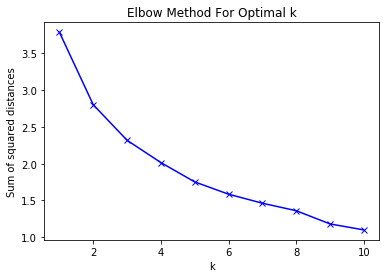

In [66]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

From the plot above, the choice for the optimal k is not so straightforward as even though k = 3 seems to be the elbow point, the sum of squared distances is quite high there. A choice between k=4 and k=7 seems viable, so let's go with k = 5 and run *k*-means to cluster the neighborhoods into 5 clusters.

In [67]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(la_grouped_clustering)

In [68]:
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 0, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [69]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

la_merged = la_subset

# merge la_grouped with la_subset to add latitude/longitude for each neighborhood
la_merged = la_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

la_merged.head() # check the last columns!

,Zip Code,Neighborhood,Street,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,90001,Los Angeles,79TH ST,33.968964,-118.260627,0,Coffee Shop,Food Truck,American Restaurant,Grocery Store,Shipping Store,Burger Joint,Mexican Restaurant,ATM,Korean Restaurant,Chinese Restaurant
1,90002,"Watts, Southeast Los Angeles",107TH ST,33.946941,-118.247758,0,Women's Store,Sandwich Place,Donut Shop,Food Truck,Grocery Store,Bank,Park,Pharmacy,Fried Chicken Joint,Flower Shop
2,90003,Southeast Los Angeles,MAIN ST,33.964656,-118.273691,4,Fast Food Restaurant,Mexican Restaurant,Ice Cream Shop,Pizza Place,Fried Chicken Joint,Food,Taco Place,Music Venue,Diner,Discount Store
3,90004,Koreatown,BEVERLY BLVD,34.076803,-118.306626,0,Korean Restaurant,Café,Coffee Shop,Bakery,Japanese Restaurant,Ice Cream Shop,Sushi Restaurant,Bubble Tea Shop,Bar,BBQ Joint
4,90005,Koreatown,8TH ST,34.058886,-118.305659,0,Korean Restaurant,Café,Coffee Shop,Bakery,Japanese Restaurant,Ice Cream Shop,Sushi Restaurant,Bubble Tea Shop,Bar,BBQ Joint


We need the cluster labels to be of type int and not contain missing values i.e. NaN values for the further analysis to work so let's quickly it out.

In [70]:
la_merged['Cluster Labels'].dtypes

dtype('int32')

The labels are type int so that's okay. Let's check for NaN values.

In [71]:
la_merged['Cluster Labels'].value_counts(dropna=False)

0    46
4     5
3     1
2     1
1     1
Name: Cluster Labels, dtype: int64

There are none! **Finally, let's visualize the resulting clusters!**

In [72]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in (range(kclusters))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(la_merged['Latitude'], la_merged['Longitude'], la_merged['Neighborhood'], la_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examining the clusters

Let's now examine each cluster and discover the distinctive venue categories that define each cluster.

#### Cluster 1

In [73]:
la_merged.loc[la_merged['Cluster Labels'] == 0, la_merged.columns[[1] + list(range(5, la_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Los Angeles,0,Coffee Shop,Food Truck,American Restaurant,Grocery Store,Shipping Store,Burger Joint,Mexican Restaurant,ATM,Korean Restaurant,Chinese Restaurant
1,"Watts, Southeast Los Angeles",0,Women's Store,Sandwich Place,Donut Shop,Food Truck,Grocery Store,Bank,Park,Pharmacy,Fried Chicken Joint,Flower Shop
3,Koreatown,0,Korean Restaurant,Café,Coffee Shop,Bakery,Japanese Restaurant,Ice Cream Shop,Sushi Restaurant,Bubble Tea Shop,Bar,BBQ Joint
4,Koreatown,0,Korean Restaurant,Café,Coffee Shop,Bakery,Japanese Restaurant,Ice Cream Shop,Sushi Restaurant,Bubble Tea Shop,Bar,BBQ Joint
5,"Pico-Union, Koreatown",0,Ice Cream Shop,Video Game Store,Mobile Phone Shop,Greek Restaurant,Grocery Store,Diner,Spanish Restaurant,Coffee Shop,Spa,Pizza Place
6,Los Angeles,0,Coffee Shop,Food Truck,American Restaurant,Grocery Store,Shipping Store,Burger Joint,Mexican Restaurant,ATM,Korean Restaurant,Chinese Restaurant
7,Crenshaw,0,Fast Food Restaurant,Sandwich Place,Lingerie Store,Mexican Restaurant,Southern / Soul Food Restaurant,Department Store,Ice Cream Shop,Cupcake Shop,Shopping Mall,Shoe Store
8,Koreatown,0,Korean Restaurant,Café,Coffee Shop,Bakery,Japanese Restaurant,Ice Cream Shop,Sushi Restaurant,Bubble Tea Shop,Bar,BBQ Joint
10,Chinatown,0,Chinese Restaurant,Mexican Restaurant,Vietnamese Restaurant,Historic Site,Bakery,Sandwich Place,Coffee Shop,Café,Plaza,Museum
11,"Wholesale District, Downtown Los Angeles",0,Coffee Shop,Bar,Seafood Restaurant,Grocery Store,Japanese Restaurant,Café,Smoke Shop,Brewery,Food Truck,Burger Joint


#### Cluster 2

In [74]:
la_merged.loc[la_merged['Cluster Labels'] == 1, la_merged.columns[[1] + list(range(5, la_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
60,Bel Air,1,Home Service,Women's Store,Dumpling Restaurant,Food Truck,Food Stand,Food Service,Food Court,Food,Flower Shop,Flea Market


#### Cluster 3

In [75]:
la_merged.loc[la_merged['Cluster Labels'] == 2, la_merged.columns[[1] + list(range(5, la_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,"Lincoln Heights, Northeast Los Angeles",2,Pharmacy,Fast Food Restaurant,Gym,Women's Store,Donut Shop,Food Stand,Food Service,Food Court,Food,Flower Shop


#### Cluster 4

In [76]:
la_merged.loc[la_merged['Cluster Labels'] == 3, la_merged.columns[[1] + list(range(5, la_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
53,"Mount Washington, Glassell Park, Northeast Los...",3,Park,Scenic Lookout,Women's Store,Dumpling Restaurant,Food Stand,Food Service,Food Court,Food,Flower Shop,Flea Market


#### Cluster 5

In [77]:
la_merged.loc[la_merged['Cluster Labels'] == 4, la_merged.columns[[1] + list(range(5, la_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Southeast Los Angeles,4,Fast Food Restaurant,Mexican Restaurant,Ice Cream Shop,Pizza Place,Fried Chicken Joint,Food,Taco Place,Music Venue,Diner,Discount Store
9,Southeast Los Angeles,4,Fast Food Restaurant,Mexican Restaurant,Ice Cream Shop,Pizza Place,Fried Chicken Joint,Food,Taco Place,Music Venue,Diner,Discount Store
28,"El Sereno, Northeast Los Angeles",4,Mexican Restaurant,Convenience Store,Asian Restaurant,Seafood Restaurant,Liquor Store,Restaurant,Thrift / Vintage Store,Trail,Chinese Restaurant,Pizza Place
29,"Arroyo Seco, Boyle Heights",4,Mexican Restaurant,Pizza Place,Pharmacy,Burger Joint,Fried Chicken Joint,Taco Place,Fast Food Restaurant,Coffee Shop,Women's Store,Filipino Restaurant
51,East Los Angeles,4,Mexican Restaurant,Food Truck,Pizza Place,Shopping Mall,Grocery Store,Juice Bar,Women's Store,Filipino Restaurant,Event Space,Farmers Market
